In [1]:
#!pip install mlxtend
%matplotlib inline

## Import all the relevant libraries

In [104]:
import pandas as pd
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

# tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,InputLayer,MaxPool2D
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Helper functions

## collect
Helper function that loads the data from the attached tsv files
Most of the files in the tsv dir are from the first prototype where sampling rate has been at a range of 25Hz - 50Hz

In [34]:
def collect(i):
    return pd.read_csv('data/tsv_50hz_20kg/'+str(i)+'.log',sep= "\t")
    

## load_sample 
Loads the data from the sample file from dir that contains sample data with Hz sampling rate

In [84]:
def load_sample(file):
    return pd.read_csv('data/csv_100hz_8kg/'+str(file)+'.csv',sep= ";").rename(columns={'Time':'DateTime','ts':'Time','ax':'Ax','ay':'Ay','az':'Az','gx':'Gx','gy':'Gy','gz':'Gz'})    

## label_activity 
Sets the label column for the dataset

In [36]:
def label_activity(df,label):
    df['Activity'] = label

## acc_scalar
Cormalize magnitude for the accelerometer and gyro values 

In [37]:
def acc_scalar(df):
    df['Axs'] = (df['Ax'].apply(lambda x:math.sqrt(x**2)/4))
    df['Ays'] = (df['Ay'].apply(lambda x:math.sqrt(x**2)/4))
    df['Azs'] = (df['Az'].apply(lambda x:math.sqrt(x**2)/4))
    df['Gxs'] = (df['Gx'].apply(lambda x:(x+500.0)/1000.0))
    df['Gys'] = (df['Gy'].apply(lambda x:(x+500.0)/1000.0))
    df['Gzs'] = (df['Gz'].apply(lambda x:(x+500.0)/1000.0))

## magnitude
Calculate the magnitude for each of the sensor values

In [38]:
def magnitude(df):
    ax2 = df['Ax']**2
    ay2 = df['Ay']**2
    az2 = df['Az']**2
    am2 = ax2 + ay2 + az2
    
    gx2 = df['Gx']**2
    gy2 = df['Gy']**2
    gz2 = df['Gz']**2
    gm2 = gx2 + gy2 + gz2
    
    
    df['Am']=am2.apply(lambda x: math.sqrt(x)/4) 
    df['Gm']=gm2.apply(lambda x: math.sqrt(x)/500)
    
     #df['Pitch']=         math.atan2(df['Ay'][index],df['Az'][index])
      #   math.atan2(-df['Ax'][index], math.sqrt(df['Ay'][index]**2 +(df['Az'][index] **2)))

## frequency
based on the timestamp calculate the sampling frequency

In [39]:
def frequency(df):
    df['Time_Delta_ms'] = (df['Time']-df['Time'].shift()).fillna(1000).astype(int)
    df['Hz'] = (1000/df['Time_Delta_ms']).astype(int)

In [40]:
def unique_labels(df):
    return df['Activity'].unique()

## Plotting functions for individual activities

In [74]:
def plot_activity(activity, df,i=1000):
    data = df[df['Activity'] == activity][['Ax','Ay','Az']][:i]
    axis = data.plot(subplots=True, figsize=(16, 6), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_activity_normalized(activity, df,i=1000):
    data = df[df['Activity'] == activity][['Axs','Ays', 'Azs']][:i]
    axis = data.plot(subplots=True, figsize=(16, 6), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_activity_magnitude(activity, df,i=1000):
    data = df[df['Activity'] == activity][['Am', 'Gm']][:i]
    axis = data.plot(subplots=True, figsize=(16, 6), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))     

        
def plot_datasets(df,i=1000):
    for activity in unique_labels(df):
        plot_activity(activity, df,i)    

def plot_datasets_magnitude(df,i=1000):
    for activity in unique_labels(df):
        plot_activity_magnitude(activity, df,i)    

def plot_datasets_normalized(df,i=1000):
    for activity in unique_labels(df):
        plot_activity_normalized(activity, df,i)    

# Import sample data
Import the sample data from files that contain accelerometer and gyro data for individual exercises.

In [85]:
# import from files
df_row_left = pd.DataFrame().append([collect('row-left-1'),collect('row-left-2'),collect('row-left-3')],ignore_index=True)
df_row_right = pd.DataFrame().append([collect('row-right-1'),collect('row-right-2')],ignore_index=True)
df_clean = pd.DataFrame().append([collect('clean-1'),collect('clean-2')],ignore_index=True)
df_rest=collect('rest-1')
df_swing_both_hands = pd.DataFrame().append([collect('swing-both-hands-1'),collect('swing-both-hands-2'),collect('swing-both-hands-3')],ignore_index=True)
df_deadlift_both_hands=pd.DataFrame().append([collect('deadlift-both-hands-1'),collect('deadlift-both-hands-2')],ignore_index=True)
df_goblet_squat=pd.DataFrame().append([collect('goblet-squat-1'),collect('goblet-squat-2')],ignore_index=True)
df_press=pd.DataFrame().append([load_sample('singlehand_press_right_left')],ignore_index=True)

# label individual activies
label_activity(df_row_right,"Row Right")
label_activity(df_row_left,"Row Left")
label_activity(df_rest,"Rest")
label_activity(df_swing_both_hands,"Swing Both Hands")
label_activity(df_deadlift_both_hands,"Deadlift Both Hands")
label_activity(df_goblet_squat,"Goblet Squat")
label_activity(df_clean,"Clean")
label_activity(df_press,"Press")

# new frame with with all the activities
df = pd.DataFrame()
df = df.append([df_row_right,df_row_left,df_rest,df_swing_both_hands,df_deadlift_both_hands,df_goblet_squat,df_clean,df_press])

## Inspect the number of datapoints for each indivudal exercise 

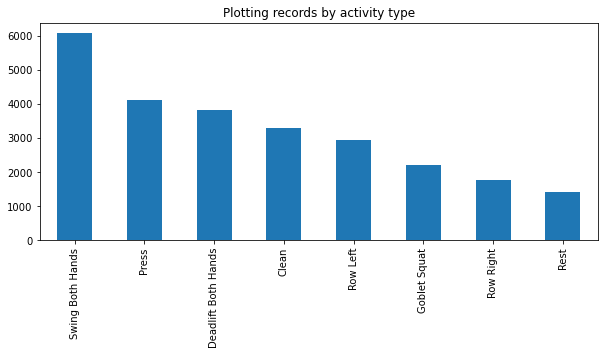

In [86]:
df['Activity'].value_counts().plot(kind='bar', title='Plotting records by activity type', figsize=(10, 4),align='center')

# Extract features
Normalize the accelerometer and gyroscope values and extract other features

In [87]:
acc_scalar(df)
magnitude(df)
frequency(df)

# Inspect the accelerometer and gyro data
Now it is time to review the actual contents of the sensor data for different excersizes and see if there are any issues with the data.



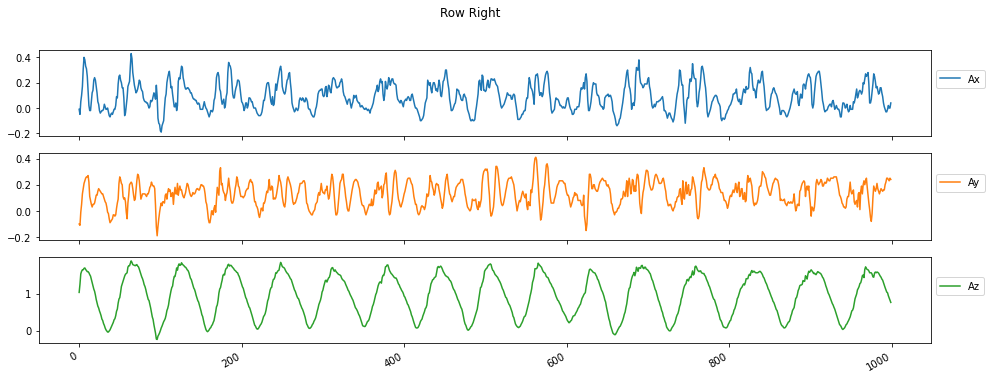

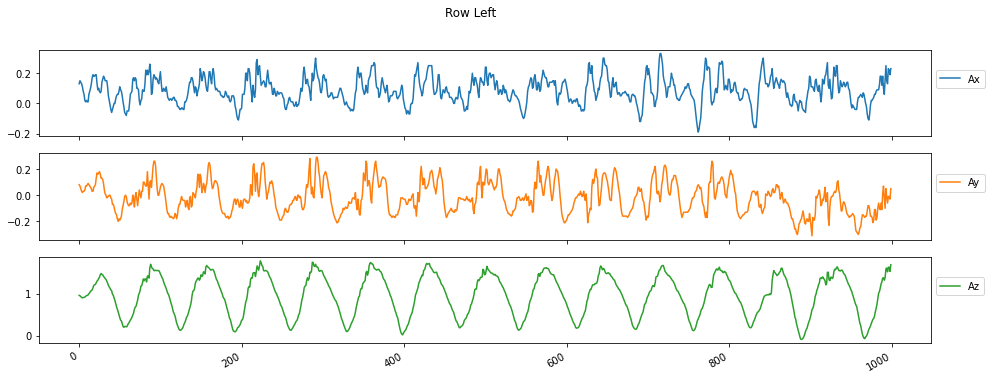

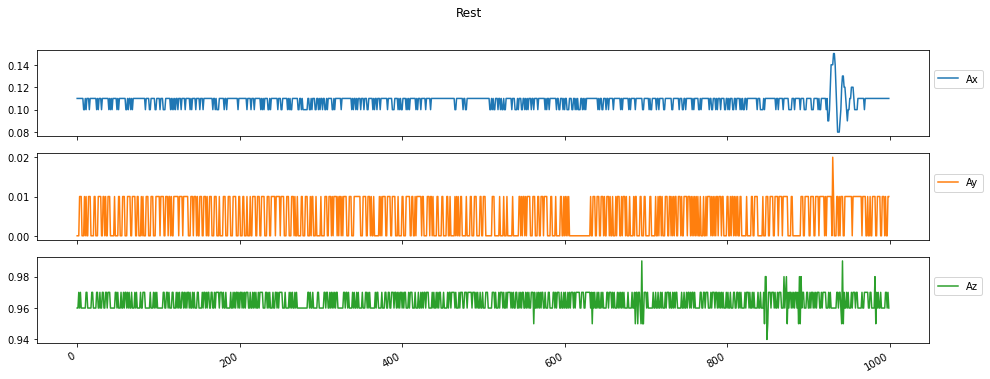

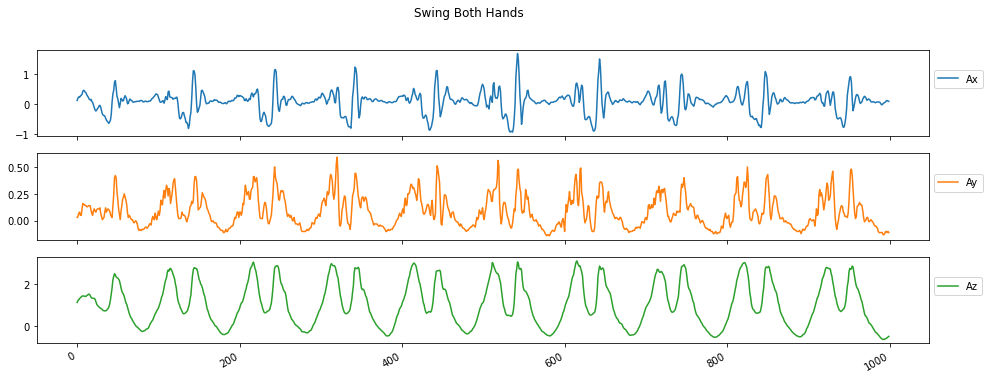

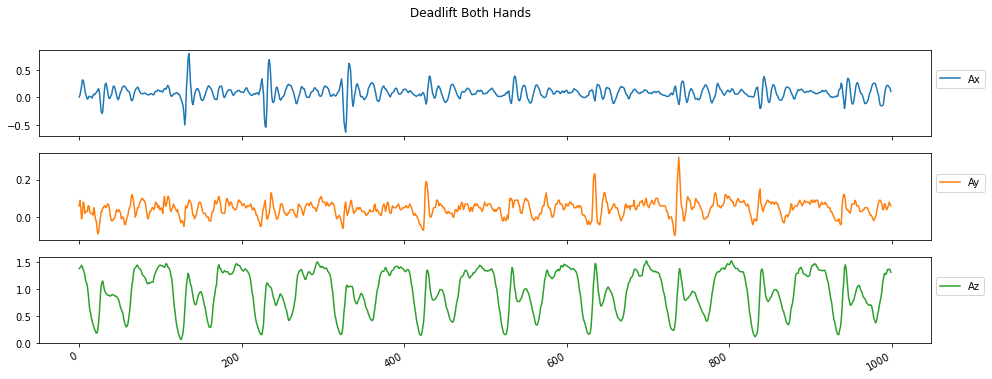

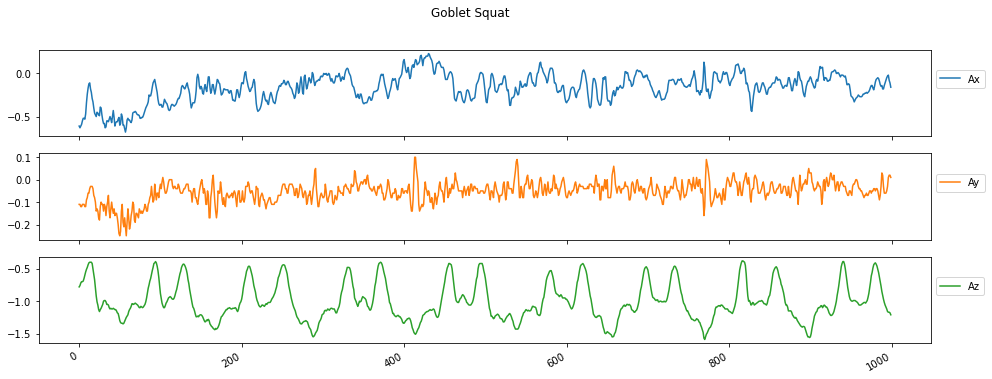

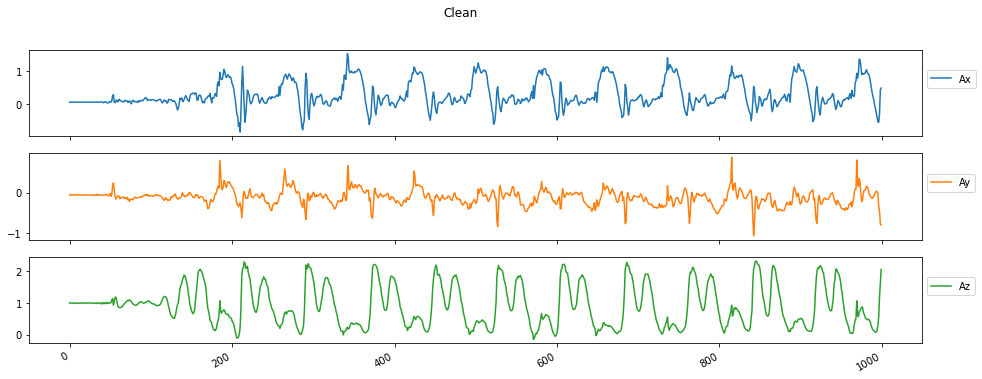

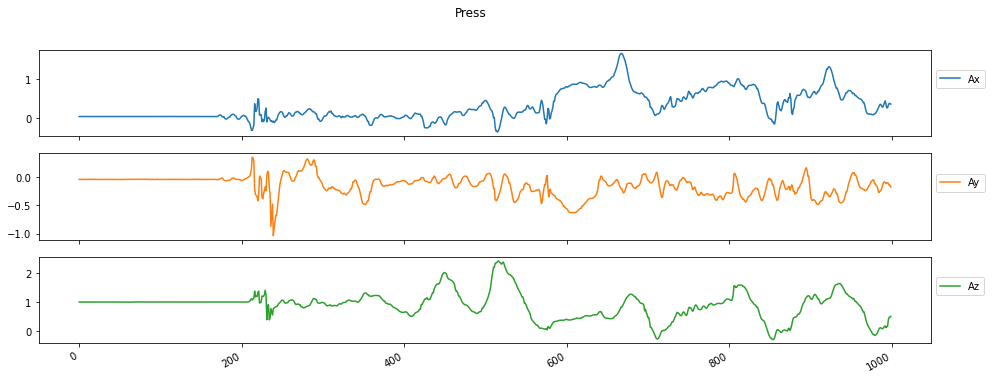

In [108]:
plot_datasets(df,i=1000)

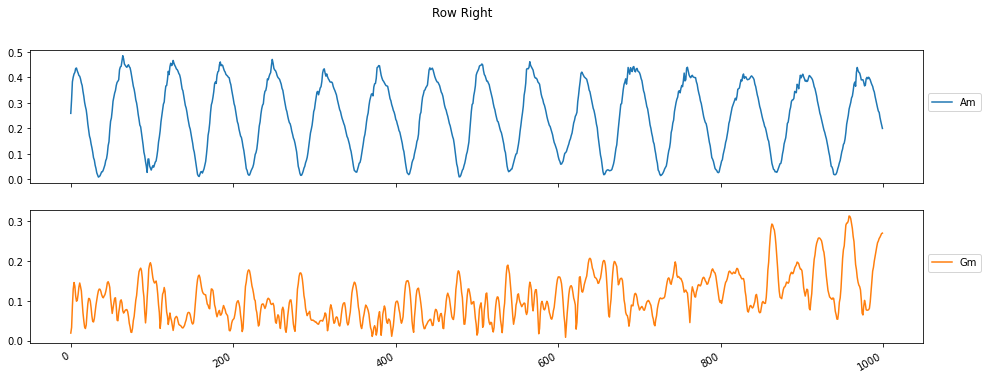

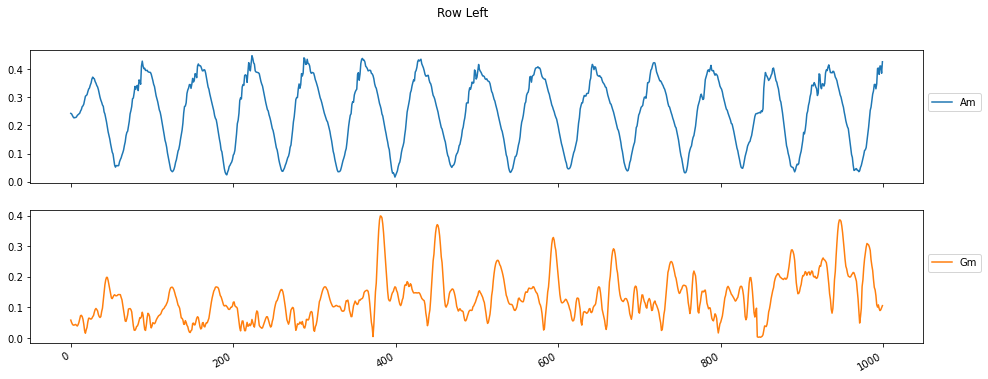

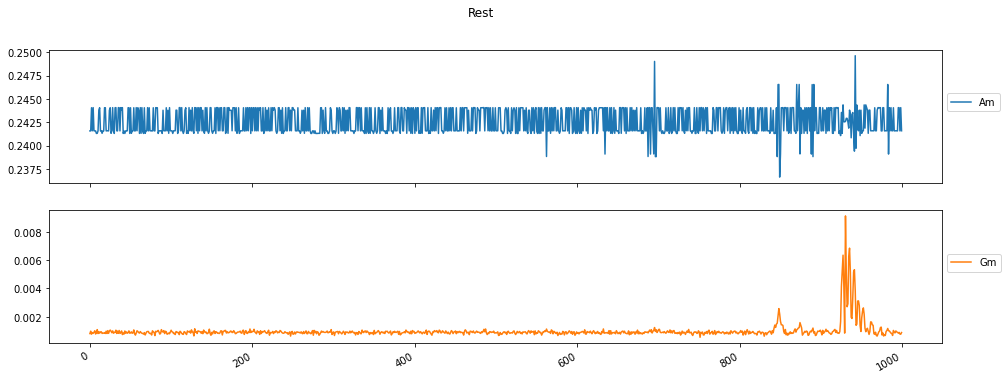

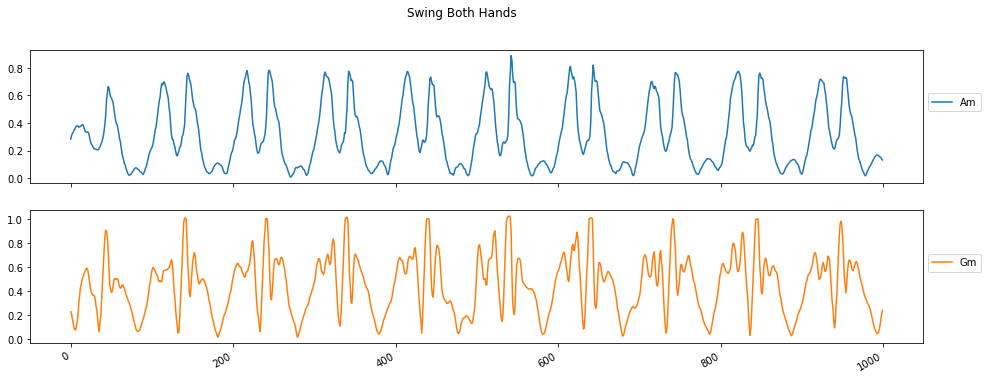

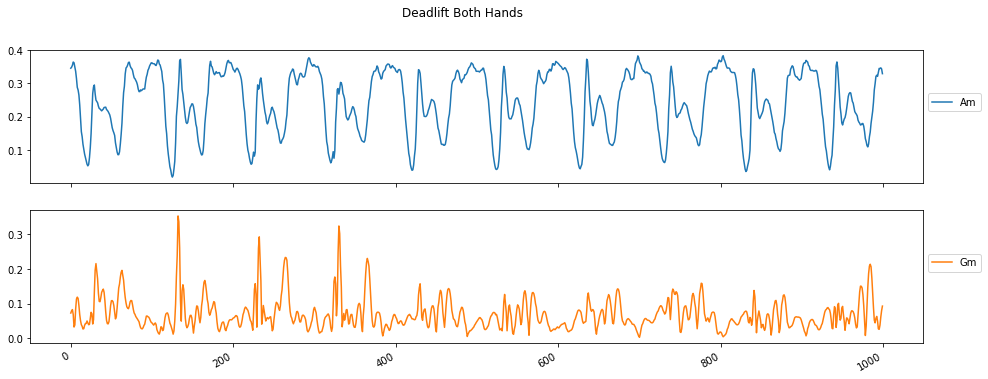

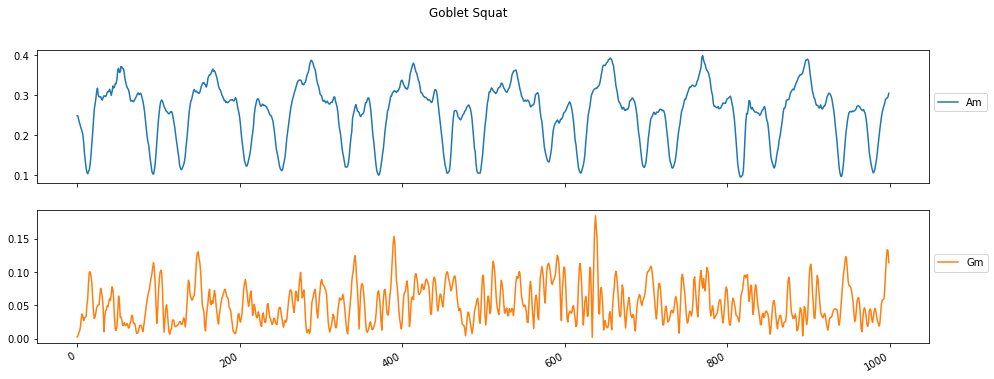

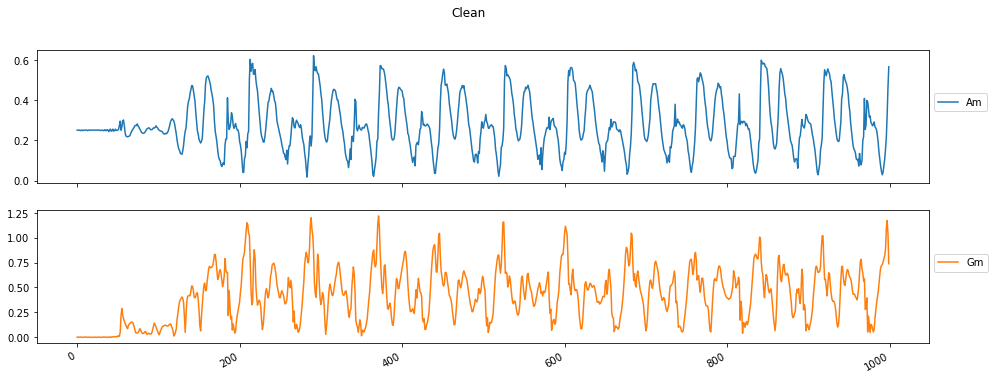

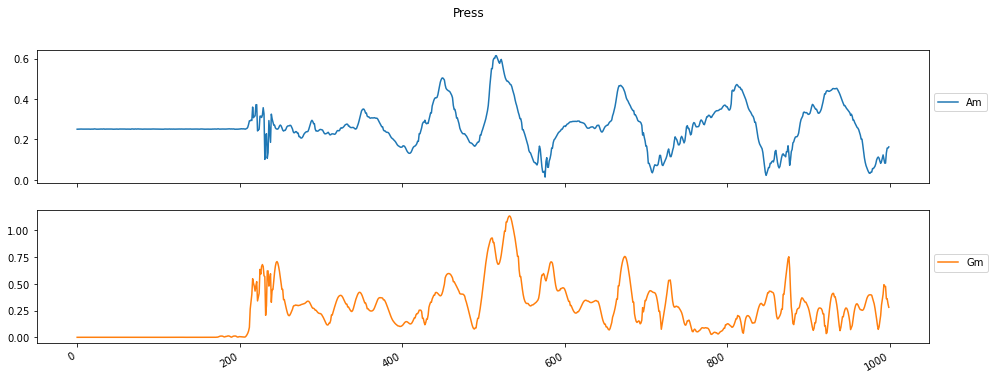

In [109]:
plot_datasets_magnitude(df,i=1000)

# Samping frequency 
The frequency is different som some of the sampling data due to the different methods that have been used for data recording.

Original prototype used to publish data over HTTP and esp32 was able to achieve a sampling rate of 50hz. 

After the first model has been trained the prediction data has been added to the samples, this decreased the sampling rate down to 25hz. This has been improved in the 3 version of the hardware where sampling rate including the prediction output is 100hz.

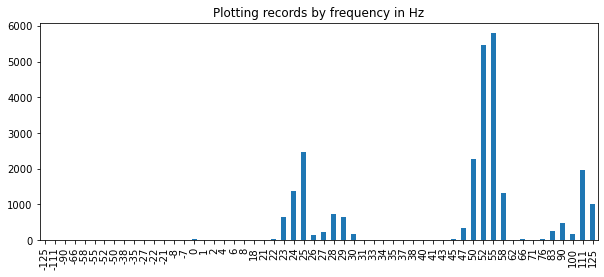

In [158]:
df['Hz'].value_counts().sort_index().plot(kind='bar', title='Plotting records by frequency in Hz', figsize=(10, 4),align='center')

## Frequency on log scale
TODO: Need to look into why there are some negative values, seems strange.

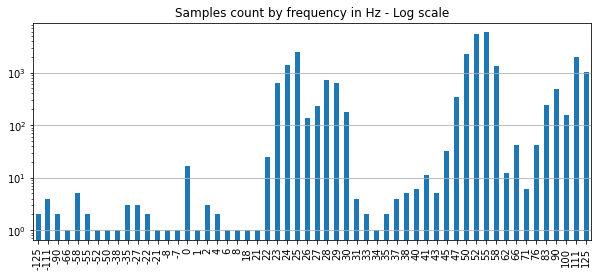

In [162]:
plt = df['Hz'].value_counts().sort_index().plot(kind='bar', title='Samples count by frequency in Hz - Log scale', figsize=(10, 4),align='center')
plt.yaxis.grid()
plt.set_yscale('log')

## Check sampling frequency on the samples acquired form the grafana
The version 3 of the prototype sends sensor data as UDP packets to a port defined in a local nodered server.

Then nodered forwards the packets to a local influxdb database. 
This allows to setup almost realtime dashboards with grafana. 

count      46.000000
mean       89.543478
std       327.416263
min         1.000000
25%         1.000000
50%         3.000000
75%        12.500000
max      1961.000000
Name: Hz, dtype: float64

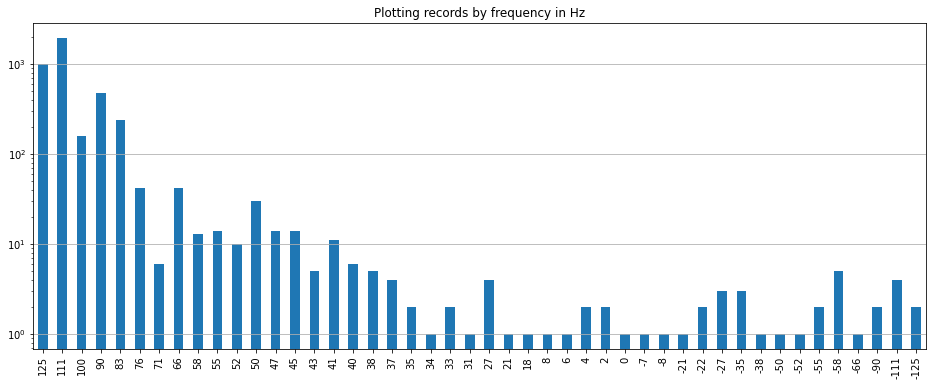

In [155]:
df_100hz = df[df['Activity']=='Press']['Hz'].value_counts().sort_index(ascending=False)
plt = df_100hz.plot(kind='bar', title='Plotting records by frequency in Hz', figsize=(16, 6),align='center')
plt.yaxis.grid()
plt.set_yscale('log')
df_100hz.describe()

In [90]:
label = LabelEncoder()
df['Label'] = label.fit_transform(df['Activity'])
df.head()

,Time,Gx,Gy,Gz,Ax,Ay,Az,Activity,Clean,Deadlift,...,Ays,Azs,Gxs,Gys,Gzs,Am,Gm,Time_Delta_ms,Hz,Label
0,17925,8.06,-4.84,-1.22,-0.01,-0.10,1.03,Row Right,NaN,NaN,...,0.0250,0.2575,0.50806,0.49516,0.49878,0.258723,0.018961,1000,1,6
1,17944,12.73,-10.38,-1.16,-0.05,-0.11,1.25,Row Right,NaN,NaN,...,0.0275,0.3125,0.51273,0.48962,0.49884,0.313957,0.032933,19,52,6
2,17965,32.04,-29.07,-3.63,0.05,-0.01,1.53,Row Right,NaN,NaN,...,0.0025,0.3825,0.53204,0.47093,0.49637,0.382712,0.086829,21,47,6
3,17983,47.76,-42.95,-6.56,0.10,0.05,1.60,Row Right,NaN,NaN,...,0.0125,0.4000,0.54776,0.45705,0.49344,0.400975,0.129132,18,55,6
4,18002,53.70,-48.11,-10.74,0.17,0.13,1.64,Row Right,NaN,NaN,...,0.0325,0.4100,0.55370,0.45189,0.48926,0.413476,0.145789,19,52,6


In [91]:
label.classes_

array(['Clean', 'Deadlift Both Hands', 'Goblet Squat', 'Press', 'Rest',
       'Row Left', 'Row Right', 'Swing Both Hands'], dtype=object)

In [92]:
def get_samples2(data):
    GESTURES = label.classes_
    SAMPLES_PER_GESTURE = 40
    NUM_GESTURES = len(GESTURES)
    ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

    inputs = []
    outputs = []

    # read each csv file and push an input and output
    for gesture_index in range(NUM_GESTURES):
      gesture = GESTURES[gesture_index]
      print(f"Processing index {gesture_index} for gesture '{gesture}'.")

      output = ONE_HOT_ENCODED_GESTURES[gesture_index]

      df = data[data['Activity'] == gesture].head(4000).copy()

      # calculate the number of gesture recordings in the file
      num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

      print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

      for i in range(num_recordings):
        tensor = []
        for j in range(SAMPLES_PER_GESTURE):            
            
          index = i * SAMPLES_PER_GESTURE + j
          # normalize the input data, between 0 to 1:
          # - acceleration is between: -4 to +4
          # - gyroscope is between: -2000 to +2000
          tensor += [
          #(df['Ax'][index] + 4.0) / 8.0,
          #(df['Ay'][index] + 4.0) / 8.0,
          #(df['Az'][index] + 4.0) / 8.0,
          #(df['Gx'][index] + 500.0) / 1000.0,
          #(df['Gy'][index]  + 500.0) / 1000.0,
          #(df['Gz'][index]  + 500.0) / 1000.0,
          
              
           math.sqrt(df['Ax'][index] ** 2) / 4,
           math.sqrt(df['Ay'][index] ** 2) / 4,
           math.sqrt(df['Az'][index] ** 2) / 4,
           math.sqrt(df['Gx'][index] ** 2) / 500,
           math.sqrt(df['Gy'][index] ** 2) / 500,
           math.sqrt(df['Gz'][index] ** 2) / 500,
          #    df['Am'][index],
          #    df['Gm'][index],
          #    math.atan2(df['Ay'][index],df['Az'][index]),
        # math.atan2(-df['Ax'][index], math.sqrt(df['Ay'][index]**2 +(df['Az'][index] **2)))
          ]

        inputs.append(tensor)
        outputs.append(output)

    # convert the list to numpy array
    inputs = np.array(inputs)
    outputs = np.array(outputs)
    return inputs, outputs
inputs,outputs = get_samples2(df)

Processing index 0 for gesture 'Clean'.
	There are 82 recordings of the Clean gesture.
Processing index 1 for gesture 'Deadlift Both Hands'.
	There are 95 recordings of the Deadlift Both Hands gesture.
Processing index 2 for gesture 'Goblet Squat'.
	There are 55 recordings of the Goblet Squat gesture.
Processing index 3 for gesture 'Press'.
	There are 100 recordings of the Press gesture.
Processing index 4 for gesture 'Rest'.
	There are 35 recordings of the Rest gesture.
Processing index 5 for gesture 'Row Left'.
	There are 73 recordings of the Row Left gesture.
Processing index 6 for gesture 'Row Right'.
	There are 44 recordings of the Row Right gesture.
Processing index 7 for gesture 'Swing Both Hands'.
	There are 100 recordings of the Swing Both Hands gesture.


In [93]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

In [94]:
model = Sequential()
#model.add(InputLayer(input_shape=inputs_train[0].shape))

#model.add(Conv2D(50,[2,2], activation='relu',input_shape=inputs_train[0].shape))
#model.add(Dropout(0.1))

#model.add(Conv2D(12,[2,2], activation='relu'))
#model.add(Dropout(0.2))

#model.add(Flatten())

#model.add(Dense(64, activation='relu'),input_shape=inputs_train[0].shape)
#model.add(Dropout(0.5))
NUM_GESTURES= len(label.classes_)
model = Sequential()
#model.add(Conv2D(50,[2,2], activation='relu',input_shape=inputs_train[0].shape))
model.add(Dense(32, activation='relu', input_shape =inputs_train[0].shape)) # relu is used for performance
model.add(Dense(32, activation='relu')) # relu is used for performance
model.add(Dense(16, activation='relu')) # relu is used for performance
model.add(Dense(NUM_GESTURES, activation='relu'))
model.add(Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy','mae'])

In [95]:
history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=10, validation_data=(inputs_validate, outputs_validate))

Epoch 1/100
35/35 [==============================] - 0s 7ms/step - loss: 2.0851 - accuracy: 0.1514 - mae: 0.2187 - val_loss: 2.0458 - val_accuracy: 0.1441 - val_mae: 0.2174
Epoch 2/100
35/35 [==============================] - 0s 2ms/step - loss: 2.0046 - accuracy: 0.2029 - mae: 0.2157 - val_loss: 1.9704 - val_accuracy: 0.1949 - val_mae: 0.2139
Epoch 3/100
35/35 [==============================] - 0s 2ms/step - loss: 1.9301 - accuracy: 0.2714 - mae: 0.2120 - val_loss: 1.9050 - val_accuracy: 0.2712 - val_mae: 0.2102
Epoch 4/100
35/35 [==============================] - 0s 2ms/step - loss: 1.8641 - accuracy: 0.3171 - mae: 0.2082 - val_loss: 1.8464 - val_accuracy: 0.2881 - val_mae: 0.2067
Epoch 5/100
35/35 [==============================] - 0s 2ms/step - loss: 1.8052 - accuracy: 0.3286 - mae: 0.2047 - val_loss: 1.7930 - val_accuracy: 0.2966 - val_mae: 0.2040
Epoch 6/100
35/35 [==============================] - 0s 2ms/step - loss: 1.7377 - accuracy: 0.3486 - mae: 0.2010 - val_loss: 1.7308 - v

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a485951490>)

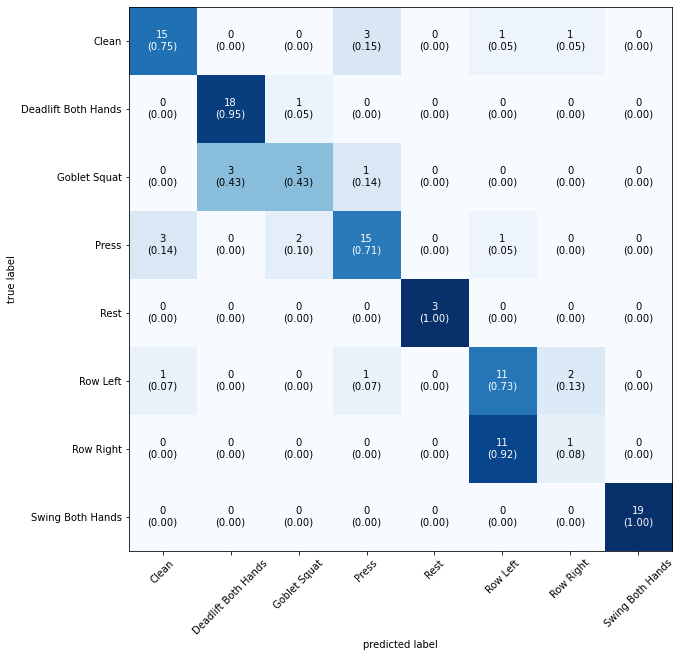

In [96]:
y_pred = model.predict_classes(inputs_test)


rounded_labels=np.argmax(outputs_test, axis=1)
rounded_labels[1]

mat = confusion_matrix(rounded_labels,y_pred)
plot_confusion_matrix(mat,class_names=label.classes_, show_normed=True,figsize=(10,10))

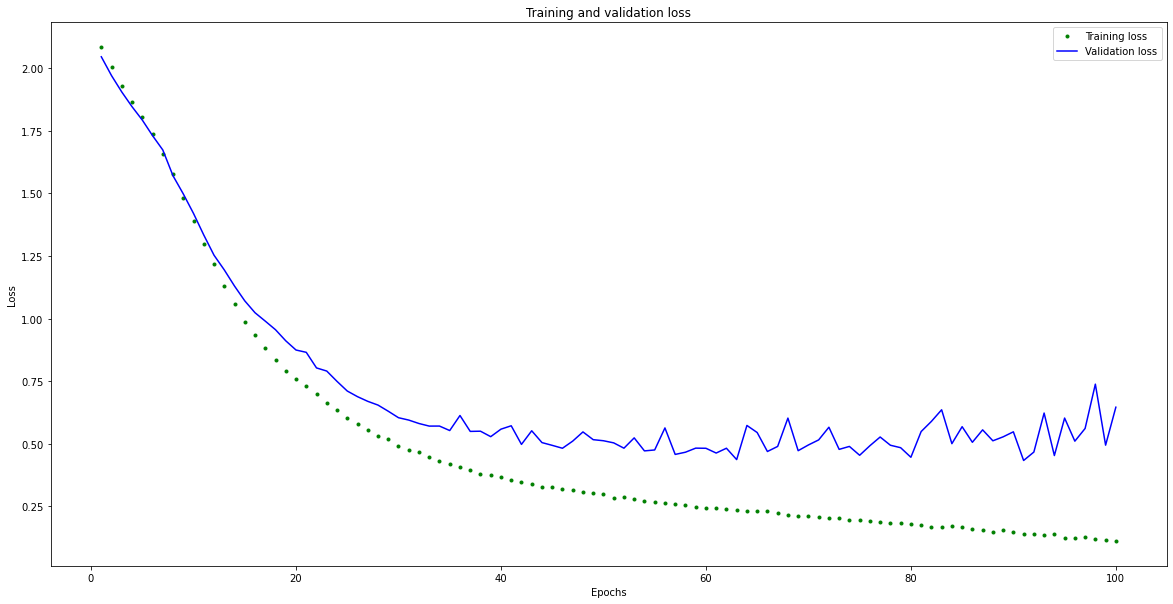

[20.0, 10.0]


In [97]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

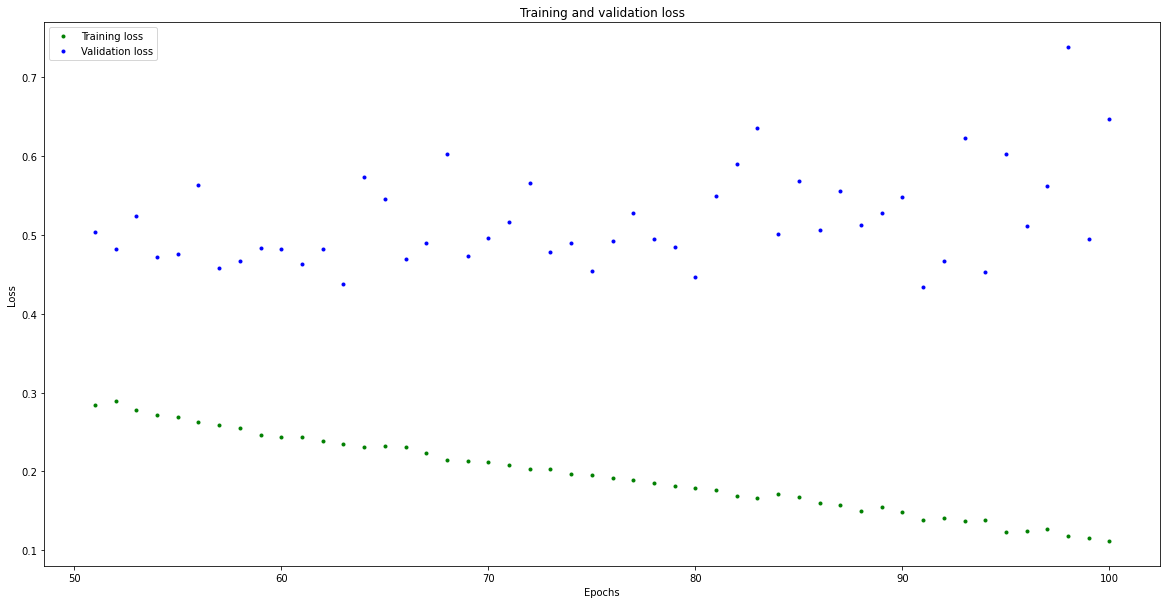

In [99]:
# graph the loss again skipping a bit of the start
SKIP = 50
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

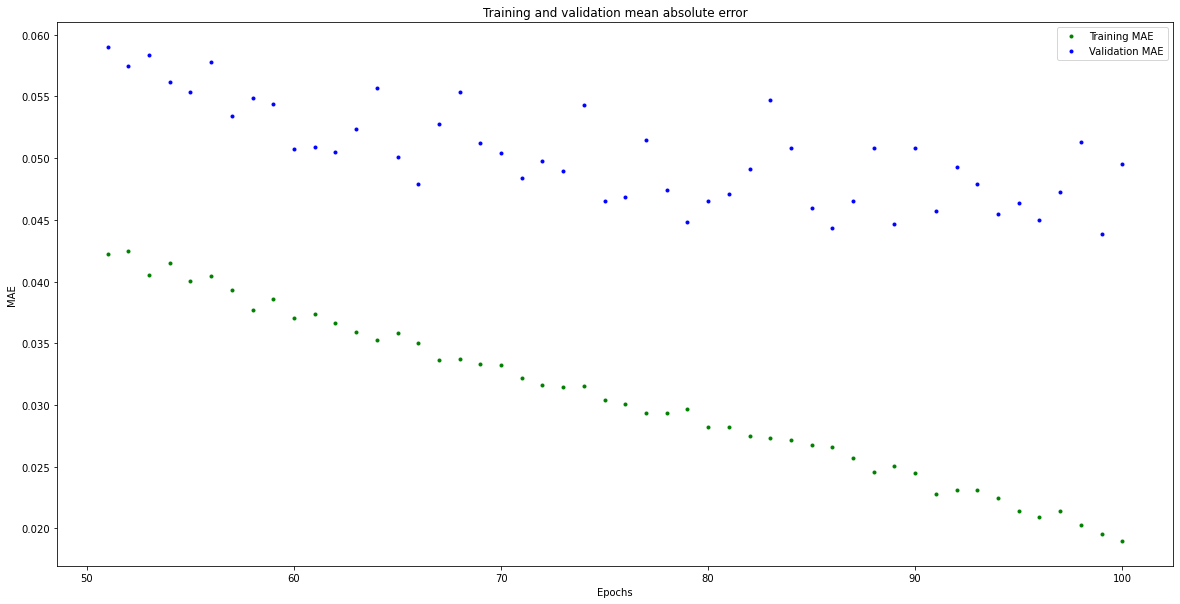

In [100]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [107]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("kettle.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("kettle.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: C:\Users\niig\AppData\Local\Temp\tmp6ip9phhm\assets


INFO:tensorflow:Assets written to: C:\Users\niig\AppData\Local\Temp\tmp6ip9phhm\assets


Model is 40520 bytes


In [ ]:
echo "const unsigned char model[] = {" > model.h
cat kettle.tflite | xxd -i             >> model.h
echo "};"                              >> model.h
